In [74]:
from gensim.models import Word2Vec, KeyedVectors
import json
import glob
from collections import defaultdict
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
import re
from itertools import combinations
from scipy.stats import spearmanr

In [75]:
authors = sorted(["marx_engels", "stalin", "trotzki", "kautsky", "lenin", "gramsci", "luxemburg", "thaelmann", "bernstein", "mao"])

# Create wordembeddings for subcorpora

## Load raw data

In [12]:
def load_data(files):
    data = []
    for f in files:
        with open(f) as inf:
            data.append(json.load(inf))   
    # return sentences in flat format, ignoring text or work boundaries
    return [sentence for works in data for texts in works.values() for sentence in texts]

In [13]:
raw_data = {}
for author in authors:
    raw_data[author] = load_data(glob.glob(f"../json/{author}/*"))

### annotate authors to key terms

In [14]:
terms = all_terms.values()
terms = list(set([v for t in terms for v in t]))

for author, sentences in raw_data.items():
    for i, sent in enumerate(sentences):
        for j, tok in enumerate(sent):
            for term in terms:
                if term == tok:
                    raw_data[author][i][j] = term + "_" + author

all_data = [sentences for data in raw_data.values() for sentences in data]

## Create and save models

### for subcorpora embeddings

In [5]:
models = {}
for author, sentences in raw_data.items():
    print(f"working on {author}...")
    models[author] = Word2Vec(sentences, size=300, min_count=5, window=100, workers=5, iter=15).wv  # only storing vectors
print("done.")

working on bernstein...
working on gramsci...
working on kautsky...
working on lenin...
working on luxemburg...
working on mao...
working on marx_engels...
working on stalin...
working on thaelmann...
working on trotzki...
done.


In [7]:
for author, model in models.items():
    model.save(f"../models/{author}_iter15.model")

### for annotated key terms

In [16]:
model = Word2Vec(all_data, size=300, min_count=5, window=100, workers=5, iter=15).wv

In [17]:
model.save("../models/all_annotated.model")

In [25]:
model.similarity("wert_n_stalin", "wert_n_marx_engels")

0.32301778

# Load pre-trained models

## Models for each author

In [76]:
models = {}
for author in authors:
    models[author] = KeyedVectors.load(f"../models/{author}_iter15.model", mmap="r")

## One model for all

In [12]:
model = KeyedVectors.load("../models/all_annotated.model", mmap="r")

# Create theory embeddings

In [77]:
all_terms = {"Politische Ökonomie": ["wert", "ware", "klasse"],
             "Philosophie": ["dialektik", "widerspruch", "aufhebung"],
             "Staatstheorie": ["staat", "bürokratie", "diktatur"],
             "Sozialismusverständnis": ["sozialismus", "diktatur"],
             "Strategie und Taktik": ["revolution", "bündnis", "reform"]}
all_terms = {cat: [w+"_n" for w in words] for cat, words in all_terms.items()}
term_cats= sorted(all_terms.keys())

In [78]:
class TheoryEmbeddings:
    def __init__(self, models, terms, word_number=50, min_similarity=.5, prio="word_number"):
        # create posibillity to weigh terms
        if type(terms[0]) == tuple:
            self.terms = [t[0] for t in terms]
            self.term_weight = [t[1] for t in terms]
        else:
            self.terms = terms
        
        self.topn = {}
        self.compared_words = defaultdict(set)
        for author, model in models.items():
            this_topn = {}
            for term in self.terms:
                try:
                    this_topn[term] = model.most_similar(term, topn=word_number)
                except KeyError:
                    print(f"WARNING! '{term}' not in vocabulary of {author}!")
                    this_topn[term] = []
                if prio == "min_similarity":
                    this_topn[term] = [w for w in this_topn[term] if w[1] >= min_similarity]
                self.compared_words[term].update(set(t[0] for t in this_topn[term]))
            self.topn[author] = this_topn
        self.compared_words = {term: sorted(list(words)) for term, words in self.compared_words.items()}
        
        self.vectors = defaultdict(lambda: defaultdict(list))
        for author, model in models.items():
            for term in terms:
                for contextword in self.compared_words[term]:
                    try:
                        v = model.similarity(term, contextword)
                    except KeyError:
                        v = 0.0
                    self.vectors[author][term].append(v)
                        
        

In [132]:
def rls(l1, l2):
    #if len(l1) != len(l2):
    #    raise ValueError("Both lists must be of same length")
    if len(l1) * len(l2) == 0:
        return np.nan
    val = 0
    inter = set(l1).intersection(set(l2))
    print(len(inter))
    for t in inter:
        w1 = 1 - l1.index(t)/len(l1)
        w2 = 1 - l2.index(t)/len(l2)
        w = w1+w2
        #print(f"w1:{w1}, w2:{w2}, l1.index(t): {l1.index(t)}, len(l1):{len(l1)}")
        
        val += ((len(l1) - abs(l1.index(t) - l2.index(t)))*w)/1.2
    val /= len(l1)**2
    return val

In [115]:
a = [i for i in range(100)]
b = [i for i in range(99, 199)]
round(rls(a,b), 10)

w1:0.010000000000000009, w2:1.0, l1.index(t): 99, len(l1):100


8.41667e-05

In [135]:
def theory_similarity(a1, a2, element, method="cos"):
    if method not in ["cos", "rls", "aa"]:
        raise ValueError(f"Method '{method}' does not exist")
    
    if method == "cos":
        n = 50
    elif method == "rls":
        n = 1000
        
    terms = all_terms[element]
    if method in ["cos", "rls"]:
        te = TheoryEmbeddings({a1: models[a1], a2: models[a2]}, terms, word_number=n)
    
    sims = []
    for term in terms:
        if method in ["cos", "rls"]:
            con1 = te.vectors[a1][term]
            con2 = te.vectors[a2][term]
        
        if method == "cos":
            sim = 1- cosine(con1, con2)
        elif method == "rls":
            sim = rls([t[0] for t in te.topn[a1][term]], [t[0] for t in te.topn[a2][term]])
        elif method == "aa":
            try:
                sim = model.similarity(f"{term}_{a1}", f"{term}_{a2}")
            except KeyError:
                return np.nan
        sims.append(sim)
    
    return sum(sims)/ len(sims)
    
    

# Visualize results in Heatmap

### For one Theorieelement

In [142]:
authors = ["marx_engels", "stalin", "trotzki", "kautsky"]
elem = "Staatstheorie"
all_sims = []
for a1 in authors:
    values = []
    for a2 in authors:
        values.append(theory_similarity(a1, a2, elem))
    all_sims.append(values)

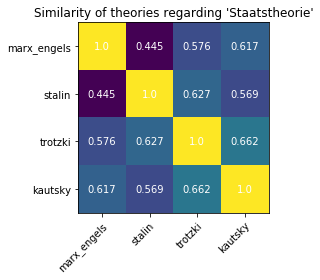

In [145]:
fig, ax = plt.subplots()
    
im = ax.imshow(all_sims)

# We want to show all ticks...
ax.set_xticks(np.arange(len(authors)))
ax.set_yticks(np.arange(len(authors)))
# ... and label them with the respective list entries
ax.set_xticklabels(authors)
ax.set_yticklabels(authors)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(authors)):
    for j in range(len(authors)):
        text = ax.text(j, i, round(all_sims[i][j],3),
                       ha="center", va="center", color="w")

ax.set_title(f"Similarity of theories regarding '{elem}'")
fig.tight_layout()
plt.show()

### For all Theorieelemente

WARNING! 'ware_n' not in vocabulary of gramsci!
158
254
200
209
207
194
217
275
141
126
283
172
189
177
89
90
169
87
200
218
WARNING! 'ware_n' not in vocabulary of thaelmann!
127
211
133
226
208
WARNING! 'ware_n' not in vocabulary of gramsci!
158
254
WARNING! 'ware_n' not in vocabulary of gramsci!
92
200
WARNING! 'ware_n' not in vocabulary of gramsci!
77
281
WARNING! 'ware_n' not in vocabulary of gramsci!
163
361
WARNING! 'ware_n' not in vocabulary of gramsci!
129
209
WARNING! 'ware_n' not in vocabulary of gramsci!
35
120
WARNING! 'ware_n' not in vocabulary of gramsci!
64
220
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
432
463
WARNING! 'ware_n' not in vocabulary of gramsci!
106
229
200
209
207
WARNING! 'ware_n' not in vocabulary of gramsci!
92
200
125
136
215
106
92
226
102
123
171
184
194
204
132
186
206
WARNING! 'ware_n' not in vocabulary of thaelmann!
49
161
109
173
210
194
217
275
WARNING! 'ware_n' not in vocabulary of gramsci!


WARNING! 'bürokratie_n' not in vocabulary of gramsci!
148
178
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
243
255
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
WARNING! 'bürokratie_n' not in vocabulary of luxemburg!
321
216
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
178
209
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
96
79
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
155
150
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
WARNING! 'bürokratie_n' not in vocabulary of thaelmann!
456
466
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
202
176
WARNING! 'bürokratie_n' not in vocabulary of bernstein!
177
221
WARNING! 'bürokratie_n' not in vocabulary of gramsci!
148
178
177
140
193
WARNING! 'bürokratie_n' not in vocabulary of luxemburg!
200
156
174
99
161
190
173
122
170
82
160
WARNING! 'bürokratie_n' not in vocabulary of thaelmann!
124
175
210
104
199
WARNING! 'bürokratie_n' not in vocabulary of bernstein!
239
234
WARNING! 'bürokrat

223
186
170
174
123
124
250
153
111
WARNING! 'reform_n' not in vocabulary of thaelmann!
204
171


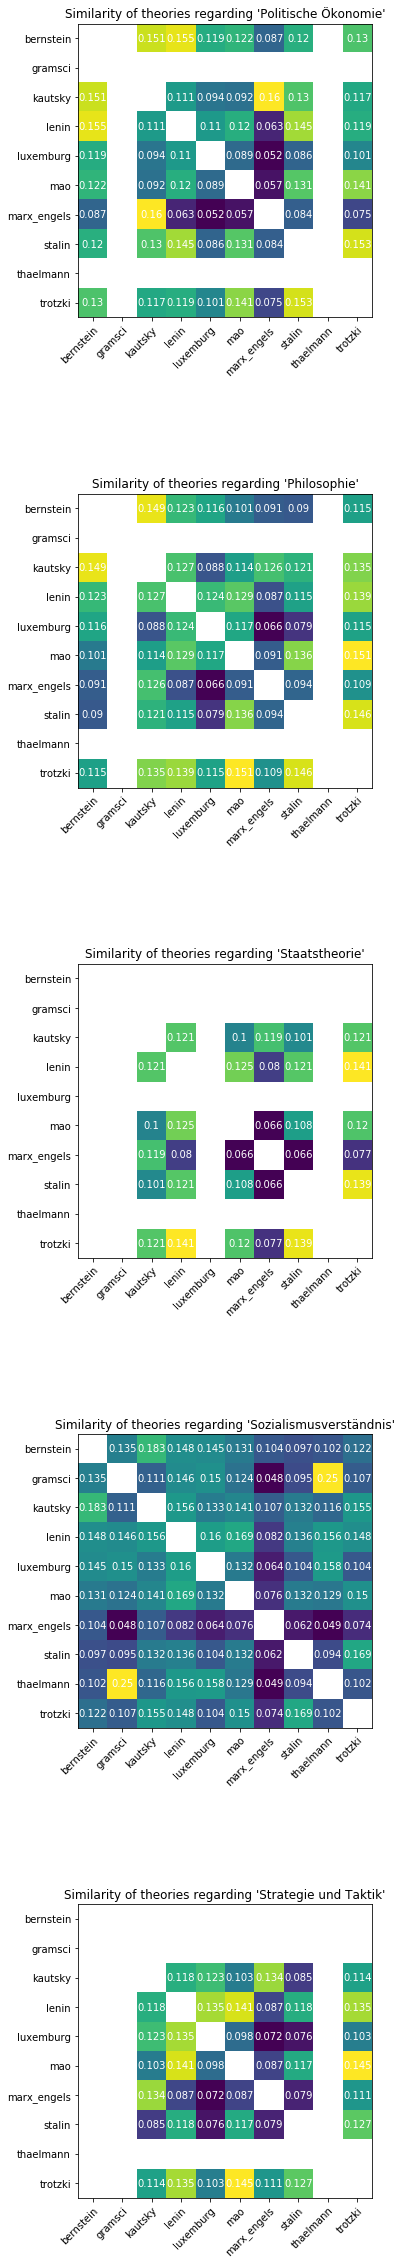

In [136]:
method = "rls"

fig, axes = plt.subplots(len(all_terms), figsize=(10, 40))

results = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))  # store data

for ax, elem in zip(axes, all_terms.keys()):
    all_sims = []
    for a1 in authors:
        values = []
        for a2 in authors:
            s1, s2 = sorted((a1, a2))
            if a1 == a2:
                values.append(np.nan)
                results[elem][s1][s2] = np.nan
            else:
                v = theory_similarity(a1, a2, elem, method=method)
                values.append(v)
                results[elem][s1][s2] = v
        all_sims.append(values)
       
    ax.imshow(all_sims)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(authors)))
    ax.set_yticks(np.arange(len(authors)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(authors)
    ax.set_yticklabels(authors)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(authors)):
        for j in range(len(authors)):
            ax.text(j, i, round(all_sims[i][j], 3),
                           ha="center", va="center", color="w")

    ax.set_title(f"Similarity of theories regarding '{elem}'")

#fig.tight_layout()
plt.subplots_adjust(hspace=.6)
plt.savefig(f"figures/similarity_heatmap_{method}.pdf")

# store data
with open(f"similarities_{method}.json", "w") as json_file:
    json.dump(results, json_file)

# Evaluation

## Create stats for machine output

In [17]:
with open("similarities_aa.json") as json_file:
    results = json.load(json_file)
results

{'Philosophie': {'bernstein': {'bernstein': nan,
   'gramsci': nan,
   'kautsky': 0.3556566933790843,
   'lenin': 0.24958687524000803,
   'luxemburg': 0.2794602612654368,
   'mao': 0.2617894361416499,
   'marx_engels': 0.3201773365338643,
   'stalin': 0.2635996987422307,
   'thaelmann': nan,
   'trotzki': 0.2776361455519994},
  'gramsci': {'gramsci': nan,
   'kautsky': nan,
   'lenin': nan,
   'luxemburg': nan,
   'mao': nan,
   'marx_engels': nan,
   'stalin': nan,
   'thaelmann': nan,
   'trotzki': nan},
  'kautsky': {'kautsky': nan,
   'lenin': 0.3441418409347534,
   'luxemburg': 0.25393390903870267,
   'mao': 0.29306215047836304,
   'marx_engels': 0.4841762085755666,
   'stalin': 0.410062034924825,
   'thaelmann': nan,
   'trotzki': 0.4427031675974528},
  'lenin': {'lenin': nan,
   'luxemburg': 0.27361785372098285,
   'mao': 0.29852209488550824,
   'marx_engels': 0.3701021472613017,
   'stalin': 0.36286577582359314,
   'thaelmann': nan,
   'trotzki': 0.3808370331923167},
  'luxembu

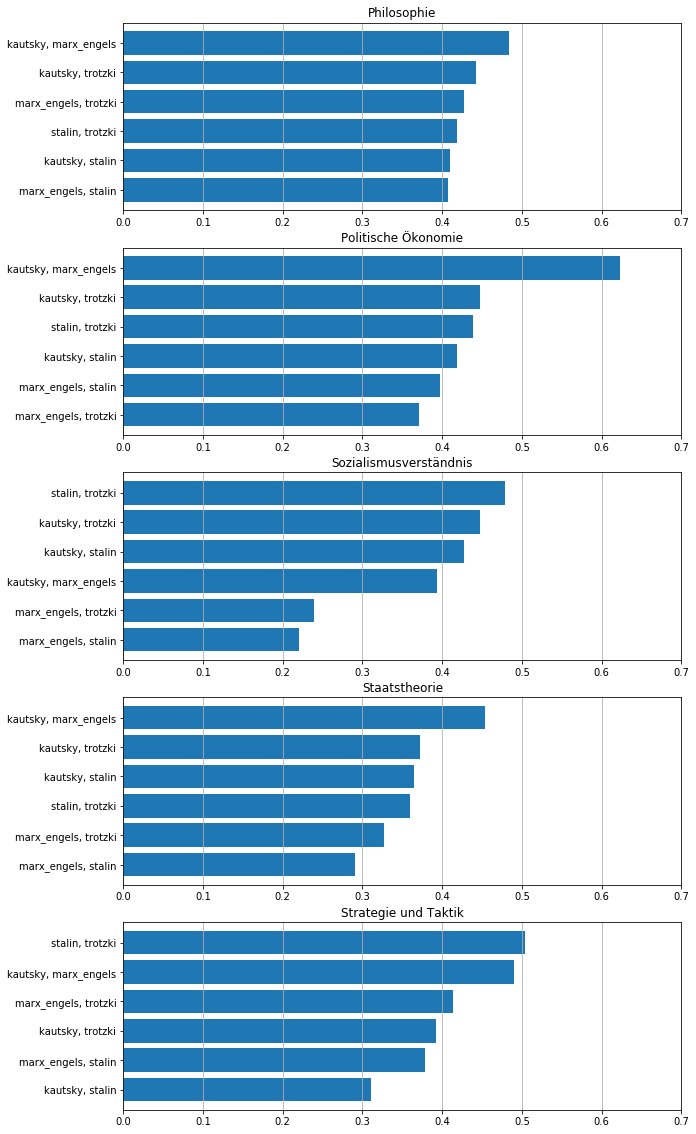

In [19]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]

fig, axes = plt.subplots(len(term_cats))

for cat, ax in zip(term_cats, axes):
    stats = results[cat]
    # filter doublettes and nans
    stats = [((a1, a2), v) for a1, compares in stats.items() for a2, v in compares.items() if a1 != a2 and not math.isnan(v)]
    # filter unimportant authors
    stats = [e for e in stats if e[0][0] in important and e[0][1] in important]
    stats.sort(key=lambda x: x[1])

    ax.barh([", ".join(x[0]) for x in stats], [x[1] for x in stats])
    ax.set_title(cat)
    ax.set_xlim(0, 0.7)
    ax.grid(axis="x")
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
fig.set_size_inches(h=20, w=10)
plt.savefig(f"figures/ranked_{method}.pdf")
plt.show()


## Create Stats for Annotations

### convert into pythonic data structure

In [23]:
def getID(name):
    name = name.lower()
    if name == "marx/engels":
        name = "marx_engels"
    return name

In [32]:
def get_cat(quest):
    trans = {"... ihrer Sozialismusvorstellungen?": "Sozialismusverständnis",
             "... ihrer ontologischen und epistemologischen Vorstellungen?": "Philosophie",
             "... ihres Verständnisses der politischen Ökonomie?": "Politische Ökonomie",
             "... ihrer Vorstellung von Strategie und Taktik?": "Strategie und Taktik",
             "... ihrer Staatstheorie?": "Staatstheorie"}
    return trans[quest]

In [34]:
annos = []
with open('../../annotationen.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        annos.append(row)

annos = [a[3:-3] for a in annos]
annos_clean = []
for a in annos:
    tmp = []
    for v in a:
        if v == "Sehr unähnlich 1":
            tmp.append("1")
        elif v == "Sehr ähnlich 10":
            tmp.append("10")
        else:
            tmp.append(v)
    annos_clean.append(tmp)
annos = annos_clean

# prepare data structure (list of dicts like above)
annos_struct = [defaultdict(lambda: defaultdict(lambda: defaultdict(int))) for _ in range(len(annos[1:]))]

for i, header in enumerate(annos[0]):
    # seperate topic and authors
    header_parts = re.match(r"(.*) \[(.*)\]", header)
    cat = get_cat(header_parts[1])
    authors = header_parts[2]
    # seperate authors
    authors = re.match(r"(.*) – (.*)", authors)
    a1 = getID(authors[1])
    a2 = getID(authors[2])
    # store values
    for anno, struct in zip(annos[1:], annos_struct):
        struct[cat][a1][a2] = int(anno[i])

for i, anno in enumerate(annos_struct):
    with open(f"similarities_a{i}.json", "w") as json_file:
        json.dump(anno, json_file)
print(annos_struct)

[defaultdict(<function <listcomp>.<lambda> at 0x7f7171fe4b70>, {'Sozialismusverständnis': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f717465abf8>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 9, 'trotzki': 4, 'kautsky': 2}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 4, 'kautsky': 2}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 6})}), 'Politische Ökonomie': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f7171fe4158>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 8, 'trotzki': 7, 'kautsky': 4}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 7, 'kautsky': 4}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 6})}), 'Philosophie': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f7171fe41e0>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 7, 'trotzki': 7, 'kautsky': 4}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 7, 'kautsky': 4}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 4})

### load from json

In [3]:
annos_struct = []
for file in glob.glob("similarities_a[0-9].json"):
    with open(file) as json_file:
        annos_struct.append(json.load(json_file))

### Visualize

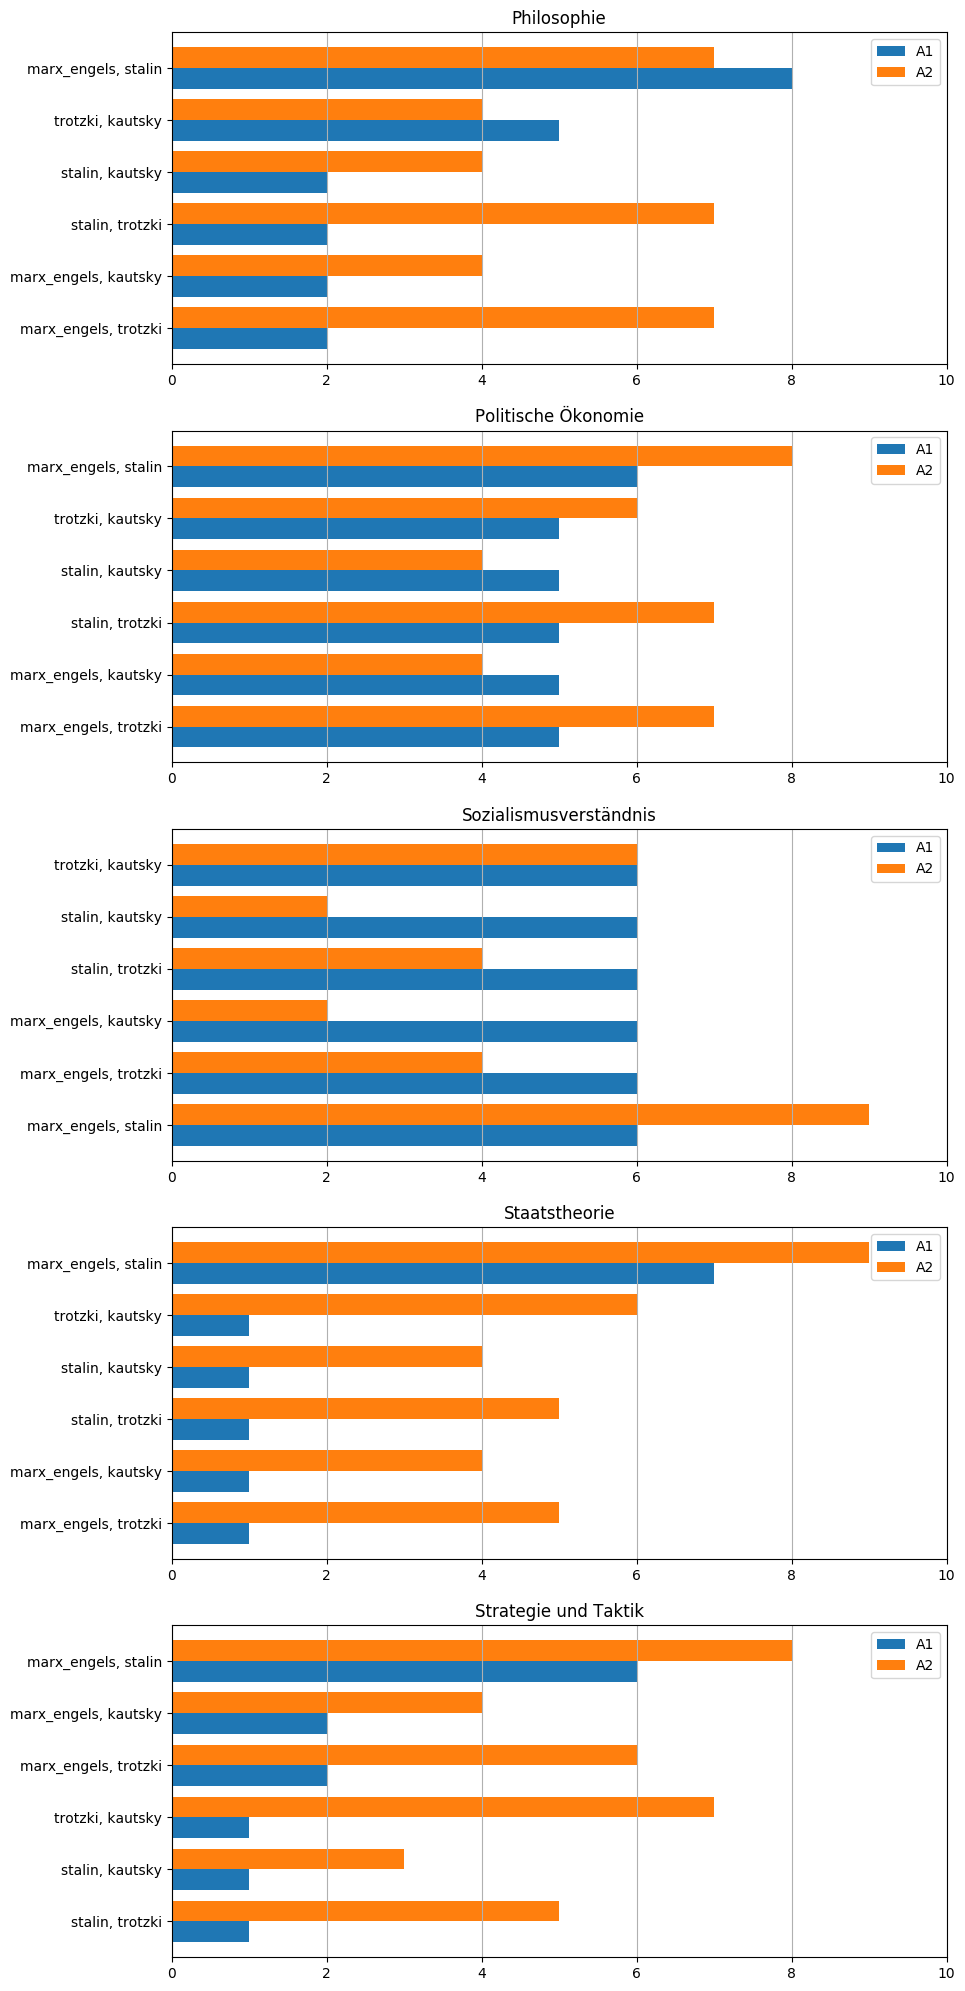

In [75]:
fig, axes = plt.subplots(len(term_cats))

for cat, ax in zip(term_cats, axes):
    reference = annos_struct[0][cat]
    # filter doublettes and nans
    reference = [((a1, a2), v) for a1, compares in reference.items() for a2, v in compares.items() if a1 != a2 and not math.isnan(v)]
    reference.sort(key=lambda x: x[1])
    reference = [x[0] for x in reference]
    
    ind = np.arange(len(reference))
    width = 1/len(annos_struct) - 2/(len(annos_struct)*10)
    
    for i, anno in enumerate(annos_struct):
        values = [anno[cat][a1][a2] for a1, a2 in reference]
        ax.barh(ind+width*i, values, width, label=f"A{i+1}")
    
    shift = width * 0.5 * (len(annos_struct) - 1)
    y_labels = [", ".join(pair) for pair in reference]
    ax.set(yticks=ind+shift, yticklabels=y_labels)
    ax.legend()
    ax.set_title(cat)
    ax.set_xlim(0,10)
    ax.grid(axis="x")

height = len(term_cats) * (4 + 0.5*len(annos_struct))
fig.set_size_inches(h=height, w=10)
plt.savefig(f"figures/annotations.pdf")
plt.show()

## calculate correlations

In [137]:
data = []
for file in glob.glob("similarities_*.json"):
    id = re.match(r"similarities_(.*).json", file).groups()[0]
    with open(file) as json_file:
        data.append((id, json.load(json_file)))
data.sort(key=lambda x: x[0])

In [138]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]

correlations = {}
names = []

for cat in term_cats:
    rows = []
    for name1, data1 in data:
        names.append(name1)
        values1 = []
        for a1, a2 in combinations(important, 2):
            try:
                values1.append(data1[cat][a1][a2])
            except KeyError:
                values1.append(data1[cat][a2][a1])
        
        row = []
        for name2, data2 in data:
            if name1 != name2:
                values2 = []
                for a1, a2 in combinations(important, 2):
                    try:
                        values2.append(data2[cat][a1][a2])
                    except KeyError:
                        values2.append(data2[cat][a2][a1])

                row.append(spearmanr(values1, values2).correlation)
            else:
                row.append(math.nan)
        rows.append(row)
    correlations[cat] = rows    

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [60]:
# new colormap for correlation values
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Greens', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name="GreenOrange")

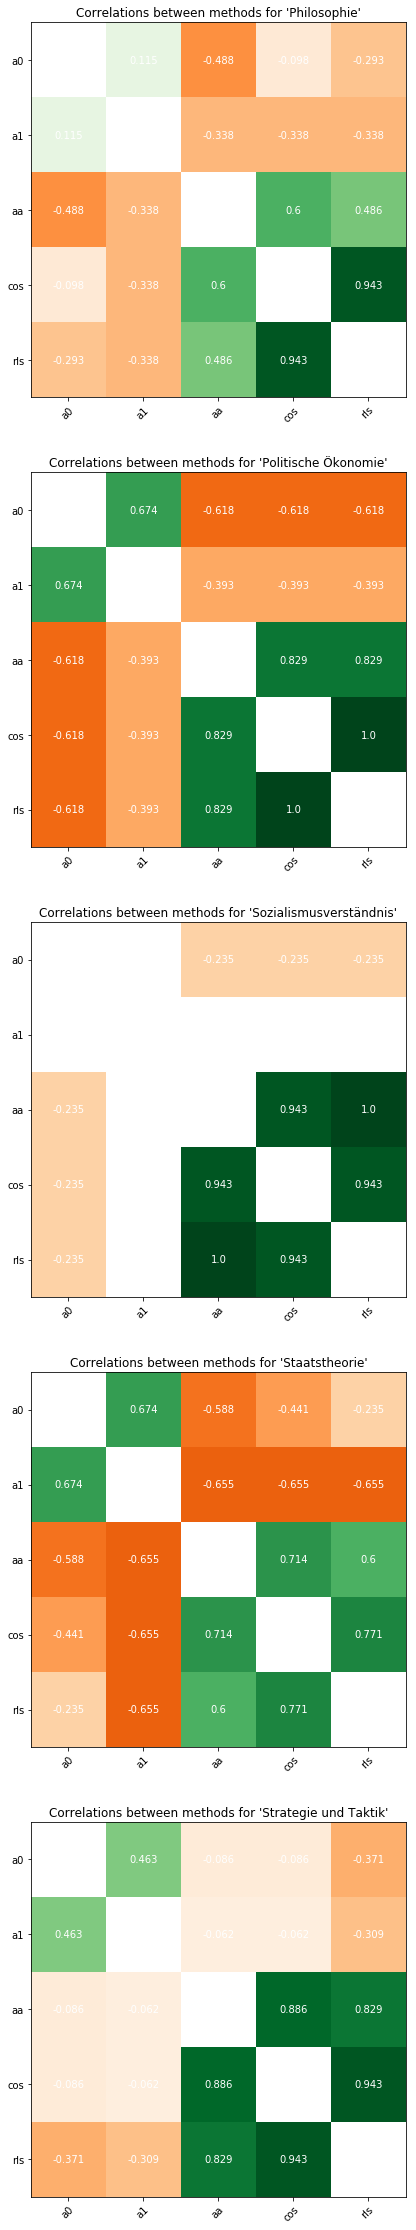

In [139]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(len(term_cats), figsize=(10, 40))
methods = [d[0] for d in data]

for cat, ax in zip(term_cats, axes):
       
    #ax.imshow([[abs(c) for c in row] for row in correlations[cat]])
    ax.imshow(correlations[cat], cmap=newcmp, norm=Normalize(vmin=-1., vmax=1.))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(methods)))
    ax.set_yticks(np.arange(len(methods)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(methods)
    ax.set_yticklabels(methods)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(correlations[cat])):
        for j in range(len(correlations[cat])):
            ax.text(j, i, round(correlations[cat][i][j], 3),
                           ha="center", va="center", color="w")

    ax.set_title(f"Correlations between methods for '{cat}'")

plt.savefig("correlations.pdf")
plt.show()